In [120]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import mir_eval

## Apply trained CNN model onto test data (TRIOS dataset)

display dataset directories

In [72]:
os.listdir('.')


['mozart',
 'MPE-TRIOS.ipynb',
 '.DS_Store',
 'clarinet.txt',
 'piano_multif0_multif0.txt',
 'piano.txt',
 'Pretty Midi Ground Truth.ipynb',
 'README.md',
 '.ipynb_checkpoints',
 '.git']

In [9]:
os.listdir('../dataset/TRIOS_dataset')

['mozart',
 '.DS_Store',
 'lussier',
 'schubert',
 'brahms',
 'take_five',
 'TRIOSS_information_sheet.pdf']

In [60]:
#pick a test audio mix 
test_audio_path = "../dataset/TRIOS_dataset/mozart/"
test_audio = "piano.wav"
save_path = "../predictions/TRIOS/mozart/"
weights_path = "../ismir2017-deepsalience/predict/"

perform multipitch estimation and output prediction as txt files (is there a limit in wavefile length? - each 40 sec)

In [61]:
os.system('python ../ismir2017-deepsalience/predict/predict_on_audio.py '
          + test_audio_path + test_audio + ' multif0 '+ save_path + ' ' + weights_path +' -f multif0')

0

In [62]:
os.listdir(save_path)

['mix_multif0_salience.npz',
 'piano_multif0_multif0.csv',
 'mix_multif0_multif0.csv']

generate ground truth labels (in the format of txt files) from midi files in TRIOS datset

In [56]:
import pretty_midi
import numpy as np
import librosa

In [110]:
def get_ground_truth(file_in, file_out): 
    sr = 100
    pm = pretty_midi.PrettyMIDI(file_in)
    pr = pm.get_piano_roll(fs=sr, times=None)
    ground_truth = []
    string_out = ''
    times = []
    freqs = []
    for tTick, notes in enumerate(pr.T):
        time = str(tTick / 100.0)
        chord = [note for note, vel in enumerate(notes) if vel > 0]
        chord_Freq = [str(librosa.core.midi_to_hz(note)) for note in chord]
        chord_Freqf = [librosa.core.midi_to_hz(note) for note in chord]
        #
        freqs.extend(chord_Freqf)
        times.extend(np.ones(np.array(chord_Freq).shape)*float(time))
        #
        written = "{0}	{1}".format(time, '	'.join(chord_Freq))
        string_out += written + '\n'
    
    f = open(file_out, 'w+') 
    f.write(string_out) 
    f.close()
    return times, freqs

In [107]:
midi_gt = test_audio_path + test_audio[:-4] + ".mid"
gt_file = save_path + "gt_" + test_audio[:-4] + ".txt"

Text(0.5, 1.0, 'piano ground truth')

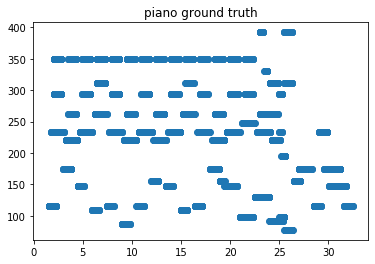

In [111]:
times,freqs = get_ground_truth(midi_gt, gt_file)
plt.scatter(times,freqs)
plt.title(test_audio[:-4]+" ground truth")

In [79]:
prediction = pd.read_csv(save_path + "piano_multif0_multif0.csv")
print(prediction.shape)

(2885, 1)


In [115]:
def plot_prediction(file_name):
    lines = open(save_path + file_name,'r').readlines()
    predict_times = []
    predict_freqs = []
    for line in lines:
        if len(line.split())>1:
            for i in range(len(line.split())):
                time = line.split()[0]
                chord_Freq = [float(freq) for freq in line.split()[1:]]
                predict_freqs.extend(chord_Freq)
                predict_times.extend(np.ones(np.array(chord_Freq).shape) * float(time))

    return predict_times, predict_freqs
    

In [116]:
print(len(predict_times),len(times),len(predict_freqs))

10470 6257 10470


In [118]:
predict_times,predict_freqs = plot_prediction("piano_multif0_multif0.csv")

Text(0.5, 1.0, 'piano prediction ')

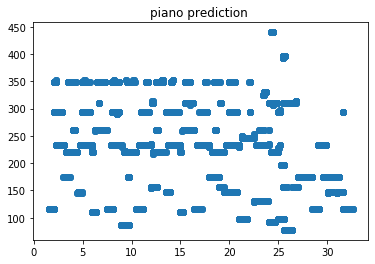

In [119]:
plt.scatter(predict_times,predict_freqs)
plt.title(test_audio[:-4]+" prediction ")

evaluate prediction vs. ground truth

In [123]:
ref_times, ref_freqs = mir_eval.io.load_ragged_time_series(save_path+"gt_piano.txt")

# load est labels
est_times, est_freqs = mir_eval.io.load_ragged_time_series(save_path+"piano_multif0_multif0.csv")

# get multif0 metrics and append
scores = mir_eval.multipitch.evaluate(ref_times, ref_freqs, est_times, est_freqs)


/Users/lilyh/anaconda3/lib/python3.6/site-packages/mir_eval/multipitch.py:410: UserWarning: Estimate times not equal to reference times. Resampling to common time base.
  warnings.warn("Estimate times not equal to reference times. "


In [124]:
scores

OrderedDict([('Precision', 0.9229908215804791),
             ('Recall', 0.658941984976826),
             ('Accuracy', 0.6246023329798516),
             ('Substitution Error', 0.017740131053220393),
             ('Miss Error', 0.32331788396995365),
             ('False Alarm Error', 0.03723829311171488),
             ('Total Error', 0.3782963081348889),
             ('Chroma Precision', 0.926124916051041),
             ('Chroma Recall', 0.6611794789835385),
             ('Chroma Accuracy', 0.6280552603613178),
             ('Chroma Substitution Error', 0.015502637046507912),
             ('Chroma Miss Error', 0.32331788396995365),
             ('Chroma False Alarm Error', 0.03723829311171488),
             ('Chroma Total Error', 0.37605881412817643)])

In [ ]:
def get_mf0_scores(est_path, ref_path, test_set_name, algorithm_name):

    all_scores = []
    est_files = glob.glob(os.path.join(est_path, '*.txt'))

    for est_file in est_files:
        file_key = "_".join(os.path.basename(est_file).replace('-', '_').split('_')[:2])
        file_key = file_key.split('.')[0]
        print(file_key)
        file_glob = glob.glob(os.path.join(ref_path, '{}*.txt'.format(file_key)))
        if len(file_glob) > 1:
            print(file_glob)
        ref_file = file_glob[0]

        # load ground truth labels
        ref_times, ref_freqs = \
            mir_eval.io.load_ragged_time_series(ref_file)

        # load est labels
        est_times, est_freqs = \
            mir_eval.io.load_ragged_time_series(est_file)

        # get multif0 metrics and append
        scores = mir_eval.multipitch.evaluate(
            ref_times, ref_freqs, est_times, est_freqs)
        scores['track'] = file_key
        all_scores.append(scores)

    # save scores to data frame
    save_path = '../outputs'
    scores_path = os.path.join(
        save_path, '{}_{}_all_scores.csv'.format(test_set_name, algorithm_name)
    )
    score_summary_path = os.path.join(
        save_path, "{}_{}_score_summary.csv".format(test_set_name, algorithm_name)
    )
    df = pandas.DataFrame(all_scores)
    df.to_csv(scores_path)
    df.describe().to_csv(score_summary_path)
    print(df.describe())